# Predict the price of the Uber ride from a given pickup point to the agreed drop-off location.
Perform following tasks:
1. Pre-process the dataset.
2. Identify outliers.
3. Check the correlation.
4. Implement linear regression and random forest regression models.
5. Evaluate the models and compare their respective scores like R2, RMSE, etc.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("uber.csv")

In [3]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [5]:
df.shape


(200000, 9)

In [6]:
df.isnull().sum()


Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [7]:
df.dropna(inplace = True)


In [8]:
df.isnull().sum()


Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [9]:
df.drop(labels='Unnamed: 0',axis=1,inplace=True)
df.drop(labels='key',axis=1,inplace=True)

In [10]:
def find_outliers_IQR(df):
   q1 = df.quantile(0.25)
   q3 = df.quantile(0.75)
   IQR = q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return outliers

In [11]:
outliers = find_outliers_IQR(df["fare_amount"])
print("number of outliers: "+ str(len(outliers)))
print("max outlier value: "+ str(outliers.max()))
print("min outlier value: "+ str(outliers.min()))
outliers

number of outliers: 17166
max outlier value: 499.0
min outlier value: -52.0


6         24.50
30        25.70
34        39.50
39        29.00
48        56.80
          ...  
199976    49.70
199977    43.50
199982    57.33
199985    24.00
199997    30.90
Name: fare_amount, Length: 17166, dtype: float64

In [12]:
outliers = find_outliers_IQR(df[["passenger_count","fare_amount"]])
outliers

,passenger_count,fare_amount
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,5.0,NaN
...,...,...
199995,NaN,NaN
199996,NaN,NaN
199997,NaN,30.9
199998,NaN,NaN


In [13]:
upper_limit = df['fare_amount'].mean() + 3*df['fare_amount'].std()
print(upper_limit)
lower_limit = df['fare_amount'].mean() - 3*df['fare_amount'].std()
print(lower_limit)

41.06517154774142
-18.345388448825922


In [14]:
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])


In [15]:
df.dtypes


fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object

In [16]:
import calendar
df['day']=df['pickup_datetime'].apply(lambda x:x.day)
df['hour']=df['pickup_datetime'].apply(lambda x:x.hour)
df['month']=df['pickup_datetime'].apply(lambda x:x.month)
df['year']=df['pickup_datetime'].apply(lambda x:x.year)
df['weekday']=df['pickup_datetime'].apply(lambda x: calendar.day_name[x.weekday()])
df.drop(['pickup_datetime'],axis=1,inplace=True)

In [17]:
df.weekday = df.weekday.map({'Sunday':0,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6})


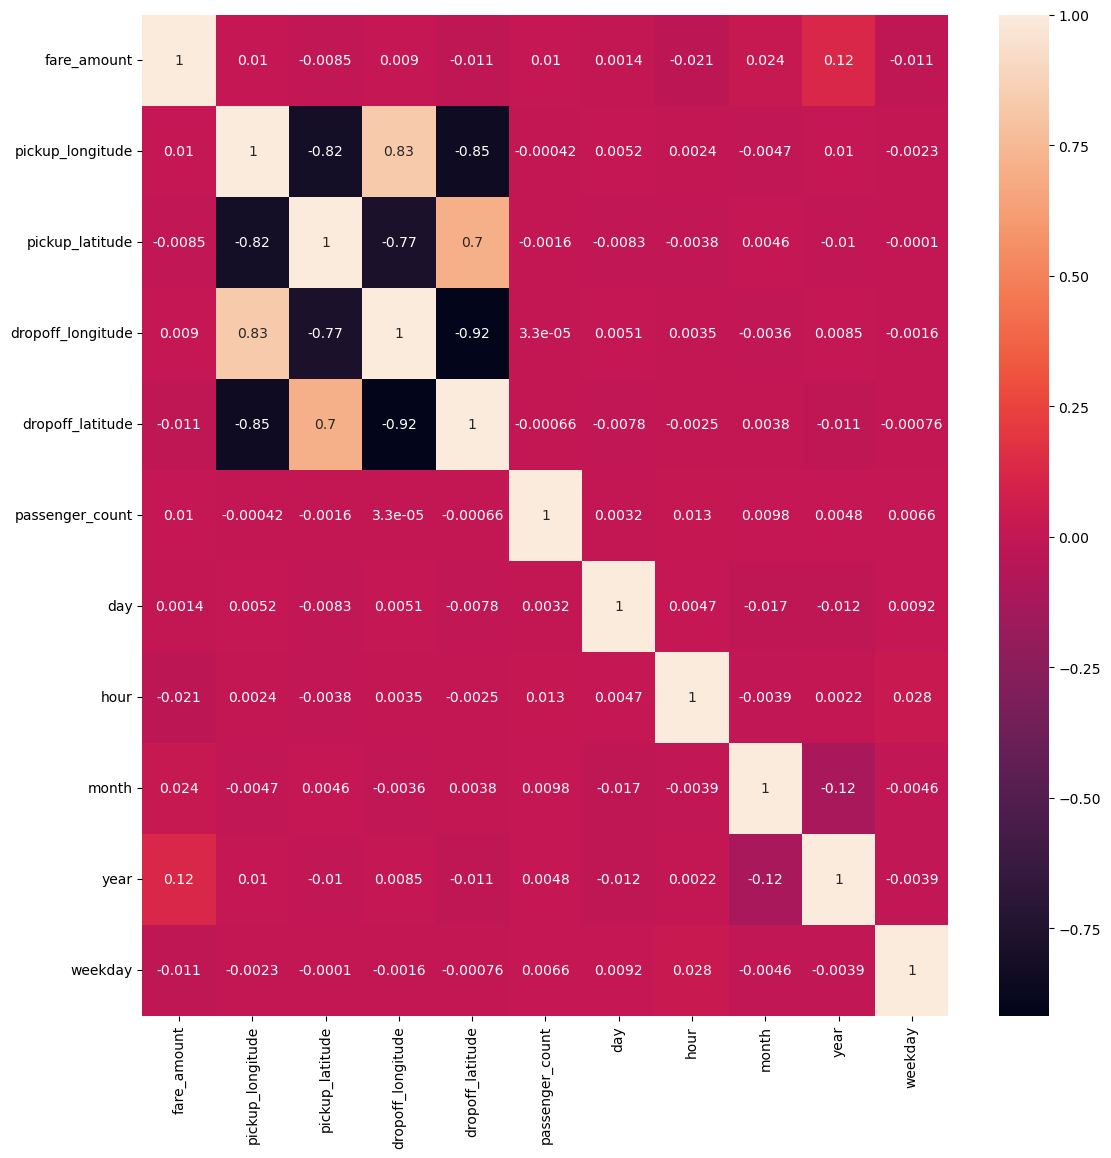

In [18]:
fig, ax = plt.subplots(figsize=(13, 13))
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
x=df.drop("fare_amount", axis=1)
x

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,hour,month,year,weekday
0,-73.999817,40.738354,-73.999512,40.723217,1,7,19,5,2015,4
1,-73.994355,40.728225,-73.994710,40.750325,1,17,20,7,2009,5
2,-74.005043,40.740770,-73.962565,40.772647,1,24,21,8,2009,1
3,-73.976124,40.790844,-73.965316,40.803349,3,26,8,6,2009,5
4,-73.925023,40.744085,-73.973082,40.761247,5,28,17,8,2014,4
...,...,...,...,...,...,...,...,...,...,...
199995,-73.987042,40.739367,-73.986525,40.740297,1,28,10,10,2012,0
199996,-73.984722,40.736837,-74.006672,40.739620,1,14,1,3,2014,5
199997,-73.986017,40.756487,-73.858957,40.692588,2,29,0,6,2009,1
199998,-73.997124,40.725452,-73.983215,40.695415,1,20,14,5,2015,3


In [21]:
y=df["fare_amount"]


In [22]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=101)


In [23]:
x_train.head()


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,hour,month,year,weekday
80768,-73.983703,40.725752,-73.972000,40.793888,1,22,1,2,2009,0
111783,-73.961175,40.760667,-73.976507,40.747570,1,7,14,3,2009,6
24615,-73.947784,40.783111,-73.955408,40.779405,1,17,11,3,2011,4
46932,-73.980596,40.733797,-73.972092,40.747297,1,15,7,1,2010,5
86655,-73.963035,40.758380,-73.987877,40.745477,2,28,19,6,2014,6


In [24]:
x_test.head()


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,hour,month,year,weekday
13588,-73.982810,40.771687,-73.977065,40.763200,1,25,22,6,2013,2
29803,-73.991985,40.725763,-73.995762,40.759797,1,20,20,2,2011,0
138265,-73.985730,40.767882,-73.998525,40.760667,1,20,14,10,2013,0
82856,-73.973200,40.748100,-73.973500,40.748200,1,17,18,11,2011,4
162747,-74.007432,40.716580,-73.986858,40.761328,1,10,22,2,2009,2


In [25]:
y_train.head()


80768     19.7
111783     7.7
24615      4.5
46932      4.5
86655     10.0
Name: fare_amount, dtype: float64

In [26]:
y_test.head()

13588      5.5
29803     11.3
138265     6.5
82856     18.1
162747    11.3
Name: fare_amount, dtype: float64

In [27]:
print(x_train.shape)
print(x_test.shape)
print(y_test.shape)
print(y_train.shape)

(159999, 10)
(40000, 10)
(40000,)
(159999,)


In [28]:
from sklearn.linear_model import LinearRegression
lrmodel = LinearRegression()
lrmodel.fit(x_train, y_train)

LinearRegression()

In [29]:
lrmodel_pred = lrmodel.predict(x_test)


In [30]:
from sklearn.ensemble import RandomForestRegressor
rfrmodel = RandomForestRegressor(n_estimators = 100, random_state = 101)
rfrmodel.fit(x_train, y_train)

RandomForestRegressor(random_state=101)

In [31]:
rfrmodel_pred = rfrmodel.predict(x_test)


In [32]:
from sklearn.metrics import r2_score
lrmodel_r2 = r2_score(y_test, lrmodel_pred)
print("R^2 value for Linear regression is : ", lrmodel_r2)

R^2 value for Linear regression is :  0.0168072118100141


In [33]:
from sklearn.metrics import r2_score
rfrmodel_r2 = r2_score(y_test, rfrmodel_pred)
print("R^2 value for Random Forest regression is : ", rfrmodel_r2)

R^2 value for Random Forest regression is :  0.7687404121015471


In [34]:
from sklearn.metrics import mean_squared_error
lrmodel_rmse = np.sqrt(mean_squared_error(y_test, lrmodel_pred))
print("RMSE value for Linear regression is : ", lrmodel_rmse)

RMSE value for Linear regression is :  9.80668770843381


In [35]:
from sklearn.metrics import mean_squared_error
lrmodel_rmse = np.sqrt(mean_squared_error(y_test, rfrmodel_pred))
print("RMSE value for Linear regression is : ", lrmodel_rmse)

RMSE value for Linear regression is :  4.756120804402443


In [36]:
base = pd.DataFrame()
base["actual"] = y_test
base["predictions"] = lrmodel_pred
base

,actual,predictions
13588,5.5,11.883663
29803,11.3,10.283565
138265,6.5,12.687850
82856,18.1,11.154900
162747,11.3,8.769830
...,...,...
136843,7.5,11.542388
116770,5.7,10.469437
130577,13.3,10.916973
31104,17.0,13.031770


In [37]:
base = pd.DataFrame()
base["actual"] = y_test
base["predictions"] = rfrmodel_pred
base

,actual,predictions
13588,5.5,6.3000
29803,11.3,11.8780
138265,6.5,7.2900
82856,18.1,5.3330
162747,11.3,12.5460
...,...,...
136843,7.5,8.4800
116770,5.7,6.0480
130577,13.3,11.9557
31104,17.0,15.5214


In [38]:
df_pred = pd.DataFrame(rfrmodel_pred)
df_pred

,0
0,6.3000
1,11.8780
2,7.2900
3,5.3330
4,12.5460
...,...
39995,8.4800
39996,6.0480
39997,11.9557
39998,15.5214
